# TME 6 : Chaînes de Markov

In [1]:
%load_ext autoreload
%autoreload 2
    
import numpy as np
import matplotlib.pyplot as plt

import utils
import tme6

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
X,Y=utils.read_data('res/lettres.pkl')
Y=np.array(Y)

Les données sont dans un format original: X et Y sont des listes, un élement de X est une lettre représentée en fait par une série d'angles (exprimés en degrés). Un exemple: 

In [4]:
print(f"{X[0]=}\n{Y[0]=}")

X[0]=array([ 36.214493, 347.719116, 322.088898, 312.230957, 314.851013,
       315.487213, 313.556702, 326.534973, 141.288971, 167.606689,
       199.321594, 217.911087, 226.443298, 235.002472, 252.354492,
       270.045654, 291.665161, 350.934723,  17.892815,  20.281025,
        28.207161,  43.883423,  53.459026])
Y[0]='a'


Lors de l'acquisition, un stylo intelligent a pris des mesures régulièrement dans le temps: chaque période correspond à un segment de droite et le stylo a calculé l'angle entre deux segments consécutifs... C'est l'information qui vous est fournie.

Pour afficher une lettre, il faut reconstruire la trajectoire enregistrée... C'est ce que fait la méthode `utils.draw_letter(array,titre)` : 

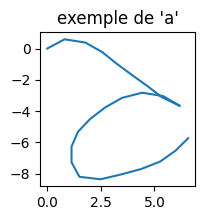

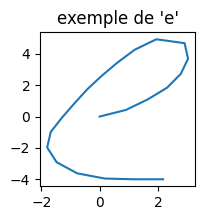

In [5]:
utils.draw_char(X[0],f"exemple de '{Y[0]}'")
utils.draw_char(X[50],f"exemple de '{Y[50]}'")

##  Apprentissage d'un modèle CM (max de vraisemblance)
### 1. Discrétisation

**1 état = 1 angle**

Il est nécessaire de regrouper les angles en un nombre fini d'états (par exemple 20)
- définir un `intervalle = 360 / n_etats`
- discrétiser tous les signaux à l'aide de la formule `np.floor(x / intervalle)`

Donner dams `tme6.py` le code de la méthode `discretise(x, d)` qui prend la liste des signaux et retourne une liste de signaux discrétisés.

In [6]:
Xd=tme6.discretise(X, 3)
print(f"{Xd[0]=}")

Xd[0]=array([0., 2., 2., 2., 2., 2., 2., 2., 1., 1., 1., 1., 1., 1., 2., 2., 2.,
       2., 0., 0., 0., 0., 0.])


### 2. Regrouper les indices des signaux par classe (pour faciliter l'apprentissage)

Cette méthode produit simplement un dictionnaire du type {lettre:np.array()}: Chaque np.array de clé c regroupe les indices de signaux correspondant à la classe c

In [7]:
groups=tme6.groupByLabel(Y)
groups

{'a': array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], dtype=int64),
 'b': array([11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21], dtype=int64),
 'c': array([22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32], dtype=int64),
 'd': array([33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43], dtype=int64),
 'e': array([44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54], dtype=int64),
 'f': array([55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65], dtype=int64),
 'g': array([66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76], dtype=int64),
 'h': array([77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87], dtype=int64),
 'i': array([88, 89, 90, 91, 92, 93, 94, 95, 96, 97], dtype=int64),
 'j': array([ 98,  99, 100, 101, 102, 103, 104, 105, 106, 107], dtype=int64),
 'k': array([108, 109, 110, 111, 112, 113, 114, 115, 116, 117], dtype=int64),
 'l': array([118, 119, 120, 121, 122, 123, 124, 125, 126, 127], dtype=int64),
 'm': array([128, 129, 130, 131, 132, 133, 134, 135, 136, 137], dtype=int64),
 'n': array([138, 139, 140, 141, 142, 143, 1

### 3. Apprendre les modèles CM

Soit {$X$} la liste des signaux correspondant à une classe {$C$} et {$d$} le nombre d'états. Donner le code de la fonction `learnMarkovModel(X, d)` qui discrétise {$X$} retourne un tuple contenant Pi et A.

Rappel:
- Initialisation de 
```python
 A = np.zeros((d, d))
 Pi = np.zeros(d)```
- Parcours de tous les signaux et incréments de A et Pi
- Normalisation (un peu réfléchie pour éviter les divisions par 0)
```python
A = A / np.maximum(A.sum(1).reshape(d, 1), 1) # normalisation
Pi = Pi / Pi.sum()```

**Note** : la solution proposée pour gérer le cas des lignes entièrement à 0 est naïve et n'est pas totalement satisfaisante. Comprendre pourquoi. On proposera une solution améliorée plus loin dans le TME. 

In [8]:

Pi_a,A_a=tme6.learnMarkovModel([X[i] for i in groups['a']],3)

print(f"{Pi_a=}\n{A_a=}")

print()

Pi_q,A_q=tme6.learnMarkovModel([X[i] for i in groups['q']],3)
print(f"{Pi_q=}\n{A_q=}")

Pi_a=array([0.36363636, 0.        , 0.63636364])
A_a=array([[0.84444444, 0.06666667, 0.08888889],
       [0.        , 0.83333333, 0.16666667],
       [0.11382114, 0.06504065, 0.82113821]])

Pi_q=array([0.2, 0.8, 0. ])
A_q=array([[0.61290323, 0.12903226, 0.25806452],
       [0.        , 0.64705882, 0.35294118],
       [0.10416667, 0.        , 0.89583333]])


### 4. Stocker les modèles dans un dictionnaire

Pour un usage ultérieur plus facile, on stocke tous les modèles dans un dictionnaire `lettre:(Pi,A)`. Écrire la fonction `learn_all_MarkovModels(X,Y,d)` qui construit ce dictionnaire avec une discrétisation en d classes. 

Remarque : cette fonction discrétise les données, groupes les données par classe et applique l'apprentissage de la chaîne de Markov sur chaque classe

In [9]:
models=tme6.learn_all_MarkovModels(X,Y,3)

print(f"{models['a']=}\n\n{models['q']=}")

models['a']=(array([0.36363636, 0.        , 0.63636364]), array([[0.84444444, 0.06666667, 0.08888889],
       [0.        , 0.83333333, 0.16666667],
       [0.11382114, 0.06504065, 0.82113821]]))

models['q']=(array([0.2, 0.8, 0. ]), array([[0.61290323, 0.12903226, 0.25806452],
       [0.        , 0.64705882, 0.35294118],
       [0.10416667, 0.        , 0.89583333]]))


## Stationnarité des CM apprises

### 5. Stationnarité par plusieurs méthodes

Pour calculer la loi stationnaire (en supposant l'ergodicité), on propose 3 méthodes:

1- on considère la fréquence de chacun des états dans la base discrétisées (mauvaise méthode).

2- on considère la marche aléatoire (par échantillonnage) comme amenant en un certain nombre ($N$) d'étapes à une approximation de la loi stationnaire

3- on calcul le point fixe de l'équation $P=A.P$ 

#### 5.1 Écrire `stationary_distribution_freq(Xd,d)` qui utilise la (mauvaise) première méthode

In [19]:
tme6.stationary_distribution_freq([Xd[i] for i in groups['a']],3)

array([0.22857143, 0.26938776, 0.50204082])

#### 5.2 Écrire `stationary_distribution_sampling(pi,A,N)` qui utilise la marche aléatoire en N étapes 

In [20]:
%%timeit -n 2
print(tme6.stationary_distribution_sampling(*models['a'],N=100000))

TypeError: stationary_distribution_sampling() got multiple values for argument 'N'

#### 5.3 Écrire `stationary_distribution_fixed_point(A,epsilon)` qui calcule (à epsilon) le point fixe de A

PS- on utilisera l'erreur quadratique entre 2 vecteurs pour le test de convergence : `np.square(np.subtract(A, B)).mean()`

In [93]:
%%timeit -n 2
print(tme6.stationary_distribution_fixed_point(models['a'][1],epsilon=1e-10))

[0.30307308 0.28281524 0.41411167]
[0.30307308 0.28281524 0.41411167]
[0.30307308 0.28281524 0.41411167]
[0.30307308 0.28281524 0.41411167]
[0.30307308 0.28281524 0.41411167]
[0.30307308 0.28281524 0.41411167]
[0.30307308 0.28281524 0.41411167]
[0.30307308 0.28281524 0.41411167]
[0.30307308 0.28281524 0.41411167]
[0.30307308 0.28281524 0.41411167]
[0.30307308 0.28281524 0.41411167]
[0.30307308 0.28281524 0.41411167]
[0.30307308 0.28281524 0.41411167]
[0.30307308 0.28281524 0.41411167]
413 µs ± 59.1 µs per loop (mean ± std. dev. of 7 runs, 2 loops each)


#### 5.4 Écrire `stationary_distribution_fixed_point_VP(A,epsilon)` qui calcule le point fixe de A en calculant le vecteur propre associé à la valeur propre 1 de $\boldsymbol{A}^T$


In [10]:
#print(tme6.stationary_distribution_fixed_point_VP(models['a'][1]))
print(tme6.stationary_distribution_fixed_point_VP(models['a']))

[array([0.3030303 , 0.28282828, 0.41414141])]


##  Inférence :  classificartion de séquences (affectation dans les classes sur critère MV)
### 1. (log)Vraisemblance d'une séquence dans un modèle

Donner le code de la méthode `logL_Sequence(s,Pi,A)` qui retourne la log-vraisemblance (likelihood) d'une séquence `s` sachant le modèle {$\lambda=\{Pi,A\}$} 

In [23]:
{k:tme6.logL_Sequence(Xd[0],*models[k]) for k in models}

{'a': -13.491085999932636,
 'b': -inf,
 'c': -inf,
 'd': -inf,
 'e': -inf,
 'f': -inf,
 'g': -inf,
 'h': -inf,
 'i': -inf,
 'j': -inf,
 'k': -inf,
 'l': -inf,
 'm': -inf,
 'n': -inf,
 'o': -inf,
 'p': -inf,
 'q': -inf,
 'r': -inf,
 's': -inf,
 't': -inf,
 'u': -inf,
 'v': -inf,
 'w': -inf,
 'x': -inf,
 'y': -inf,
 'z': -12.482856781808646}

- Le signal Xd[0] est-il bien classé ?
- D'où viennent tous les `-inf` ? 

### 2. Application de la méthode précédente pour tous les signaux et tous les modèles de lettres

L'application se fait en une ligne de code si vous avez respecté les spécifications précédentes : 

In [26]:
ll = tme6.compute_all_ll(Xd,models,Y)
print(ll)

[[-13.491086   -10.38325849 -10.70816592 ... -18.3696345  -13.74527613
  -20.59178751]
 [        -inf         -inf         -inf ...         -inf         -inf
          -inf]
 [        -inf         -inf         -inf ...         -inf         -inf
          -inf]
 ...
 [        -inf         -inf         -inf ...         -inf         -inf
          -inf]
 [        -inf         -inf         -inf ...         -inf         -inf
          -inf]
 [-12.48285678         -inf         -inf ... -14.76870842 -11.9972425
  -17.91075189]]


### 3. Évaluation des performances

Pour l'évaluation, nous proposons l'approche suivante: compter le nombre de fois où la classe prédit par max de vraisemblance est la même que la 'vraie' classe et rendre ce décompte sous forme de pourcentage.

In [30]:
print(tme6.accuracy(ll,Y))
print(tme6.accuracy(tme6.compute_all_ll(tme6.discretise(X, 20),
                                    tme6.learn_all_MarkovModels(X,Y,20),Y),
                    Y))

0.6902985074626866
0.914179104477612


**INDICE DE PERFORMANCE :** 91% de bonne classification avec 20 états, 69% avec 3 états

Si vous êtes prêt à attendre un peu, vous pouvez augmenter la valeur de max

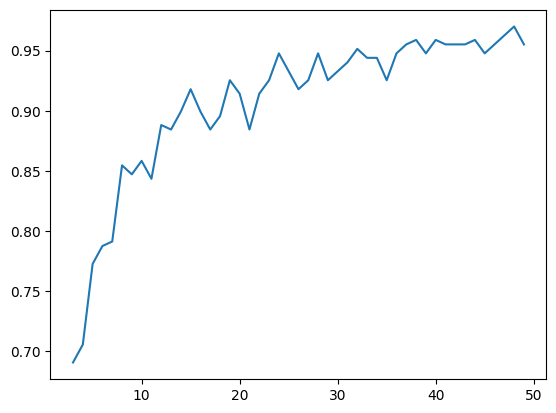

In [32]:
max=50
plt.plot(range(3,max),[tme6.accuracy(tme6.compute_all_ll(tme6.discretise(X, k),
                                    tme6.learn_all_MarkovModels(X,Y,k),Y),
                    Y) for k in range(3,max)])

## Biais d'évaluation, notion de sur-apprentissage

Dans le protocole précédent, nous avons triché:
- les données servent d'abord à apprendre les modèles...
- puis nous nous servons des mêmes données pour tester les modèles ! Les performances sont forcément bonnes ! 

Afin de palier le problème, nous allons diviser en deux la base de données: une partie servira à l'apprentissage des modèles, l'autre à leur évaluation. Pour effectuer la division, nous fournissons le code suivant: 

In [33]:
# exemple d'utilisation
X_train, X_test, ytrain, ytest = utils.separeTrainTest(X, Y, 0.8)

## Questions importantes
- Ré-utiliser les fonctions précédemment définies pour apprendre des modèles et les évaluer sans biais.
- Calculer et analyser les résultats obtenus en apprentissage et en test
- Etudier l'évolution des performances en fonction de la discrétisation

In [35]:
d=20
learn_models=tme6.learn_all_MarkovModels(X_train,ytrain,d)
#print(f"{learn_models['a']=}")
#print(f"{learn_models['q']=}")
#print("-----------------------")

Xd_train=tme6.discretise(X_train,d)
Xd_test=tme6.discretise(X_test,d)

llApp=tme6.compute_all_ll(Xd_train,learn_models, Y)
llTest=tme6.compute_all_ll(Xd_test,learn_models, Y)

scoreApp=tme6.accuracy(llApp,ytrain)
scoreTest=tme6.accuracy(llTest,ytest)

print(f"Score en apprentissage: {scoreApp=}")
print(f"Score en test: {scoreTest=}")

Score en apprentissage: scoreApp=0.9375
Score en test: scoreTest=0.2833333333333333


## Lutter contre le sur-apprentissage
Cette base de données met en lumière le phénomène de sur-apprentissage : il y a peu de données et dès que le nombre d'états augmente, il y a trop peu d'exemple pour estimer correctement les matrices {$A, \pi$}. De nombreuses cases sont donc à 0, voire des lignes entières (d'où la sécurisation du code pour la normalisation des matrices stochastiques).

Ces 0 sont particulièrement discriminants: considérant la classe {$c$}, ils permettent d'éliminer de cette classe tout signal présentant cette caractéristique. Cette règle est trop forte compte tenu de la taille de la base d'apprentissage. Nous proposons une astuce pour palier cette faiblesse : lors du comptage, initialiser les matrices {$A, \pi$} avec ones au lieu de zeros . On fait semblant d'avoir observer une transition de chaque type avant même le début du comptage.

Comparer les performances en test.

In [101]:
d=20

learn_models=tme6.learn_all_MarkovModels(X_train,ytrain,d)

Xd_train=tme6.discretise(X_train,d)
Xd_test=tme6.discretise(X_test,d)

llApp=tme6.compute_all_ll(Xd_train,learn_models, Y)
llTest=tme6.compute_all_ll(Xd_test,learn_models, Y)

scoreApp=tme6.accuracy(llApp,ytrain)
scoreTest=tme6.accuracy(llTest,ytest)

print(f"Score en apprentissage : {scoreApp=}")
print(f"Score en test : {scoreTest=}")


learn_models=tme6.learn_all_MarkovModels_Laplace(X_train,ytrain,d)


llApp=tme6.compute_all_ll(Xd_train,learn_models)
llTest=tme6.compute_all_ll(Xd_test,learn_models)

scoreApp=tme6.accuracy(llApp,ytrain)
scoreTest=tme6.accuracy(llTest,ytest)

print(f"Score en apprentissage : {scoreApp=}")
print(f"Score en test : {scoreTest=}")


Score en apprentissage : scoreApp=0.9375
Score en test : scoreTest=0.2833333333333333
Score en apprentissage : scoreApp=0.8413461538461539
Score en test : scoreTest=0.6666666666666666


### Accuracy en train/test avec modèle régularisé 

In [36]:
min=3
max=50

acc_reg_train = [tme6.accuracy(tme6.compute_all_ll(tme6.discretise(X_train,k),
                    tme6.learn_all_MarkovModels_Laplace(X_train,ytrain,k),Y),ytrain) 
                         for k in range(min,max)]

acc_reg_test = [tme6.accuracy(tme6.compute_all_ll(tme6.discretise(X_test,k),
                    tme6.learn_all_MarkovModels_Laplace(X_train,ytrain,k),Y),ytest) 
                        for k in range(min,max)]

plt.plot(range(3,max),acc_reg_train)
plt.plot(range(3,max),acc_reg_test)
plt.legend(["Acc Train", "Acc Test"]) 

AttributeError: module 'tme6' has no attribute 'learn_all_MarkovModels_Laplace'

### Accuracy en train/test avec modèle non régularisé 

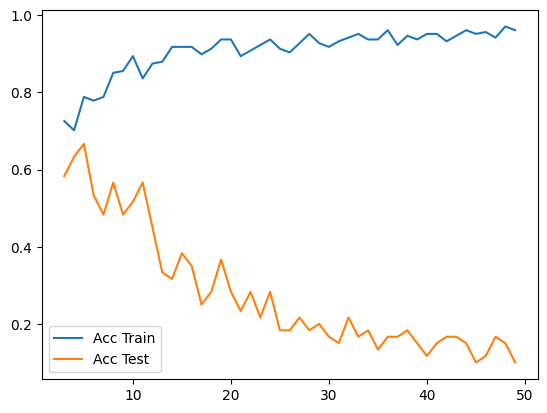

In [37]:
acc_unreg_train = [tme6.accuracy(tme6.compute_all_ll(tme6.discretise(X_train,k),
                    tme6.learn_all_MarkovModels(X_train,ytrain,k),Y),ytrain) 
                         for k in range(min,max)]

acc_unreg_test = [tme6.accuracy(tme6.compute_all_ll(tme6.discretise(X_test,k),
                    tme6.learn_all_MarkovModels(X_train,ytrain,k),Y),ytest) 
                        for k in range(min,max)]

plt.plot(range(3,max),acc_unreg_train)
plt.plot(range(3,max),acc_unreg_test)
plt.legend(["Acc Train", "Acc Test"]) 

# Partie optionnelle
## Evaluation qualitative

Nous nous demandons maintenant où se trouvent les erreurs que nous avons commises...

Calcul de la matrice de confusion: pour chaque échantillon de test, nous avons une prédiction (issue du modèle) et une vérité terrain (la vraie étiquette). En posant Nc le nombre de classes, la matrice de confusion est une matrice (Nc x Nc) où nous comptons le nombre d'échantillon de test dans chaque catégorie :

- Initialisation à 0 : 

- Pour chaque échantillon, incrément de la case (prediction, vérité)

- Tracé de la matrice : 

accuracy apprentissage = 84.13461538461539
accuracy test = 66.66666666666666


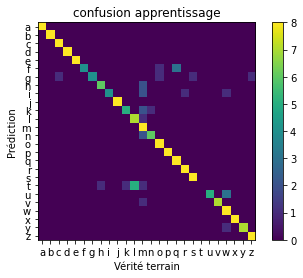

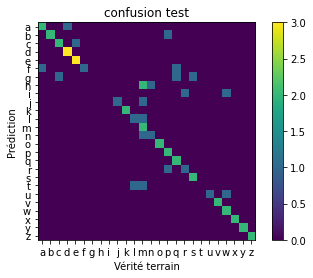

In [105]:
d=20 
X_train, X_test, ytrain, ytest = utils.separeTrainTest(X, Y, 0.8)

learn_models=tme6.learn_all_MarkovModels_Laplace(X_train,ytrain,d)
Xd_train=tme6.discretise(X_train,d)
llApp=tme6.compute_all_ll(Xd_train,learn_models)
Xd_test=tme6.discretise(X_test,d)
llTest=tme6.compute_all_ll(Xd_test,learn_models)

tme6.confusion_matrix(llApp,ytrain,"apprentissage")
tme6.confusion_matrix(llTest,ytest,"test")